# Covolutional Neural Network

In [1]:
import os
import sys
from pathlib import Path
sys.path.append("../")
from dotenv import find_dotenv, load_dotenv
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as T
import torch.nn as nn
from torch.utils.data import random_split
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard.writer import SummaryWriter

import logging
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='mylog.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.INFO)
logger.info("Setting up logging...")


from src.utils import CustomMnistDataset, imshow, create_validation_metrics, train_covnet

load_dotenv(find_dotenv())

DATA_DIR= os.getenv('DATA_DIR')
SEED = int(os.getenv('SEED')) #type: ignore
TENSORBOARD_DIR = os.getenv('TENSORBOARD_DIR')

/Users/b7064522/opt/miniconda3/envs/drenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
augmentor = nn.Sequential(
    T.RandomAffine(degrees = 22.5, translate = (0.2, 0.2), scale = (0.5, 1))
)
dataset = CustomMnistDataset(img_dir = DATA_DIR, train=True, transform=augmentor)
train_dataset, val_dataset = random_split(
    dataset,
    [0.75, 0.25],
    generator=torch.Generator().manual_seed(SEED)
    )


In [3]:
BATCH_SIZE = 10
SHUFFLE = True
EPOCHS = 10
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = SHUFFLE)
val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = SHUFFLE)


## 784 - **[24C5-P2S2]** - 256 - 10

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 24, 5) # (24, 24, 24)
        self.pool = nn.MaxPool2d(2, 2) # (24, 12, 12)
        self.fc1 = nn.Linear(24 * 12 * 12, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [5]:
train_dict = train_covnet(
    net = Net(),
    dataloader = train_dataloader,
    epochs = EPOCHS,
    optimizer_wrapper = lambda x: optim.Adam(x, lr=0.001),
    criterion = nn.CrossEntropyLoss(),
    writer = SummaryWriter(Path(TENSORBOARD_DIR, 'exp1')), #type; ignore
    val_dataloader = val_dataloader
)

### Plotting examples

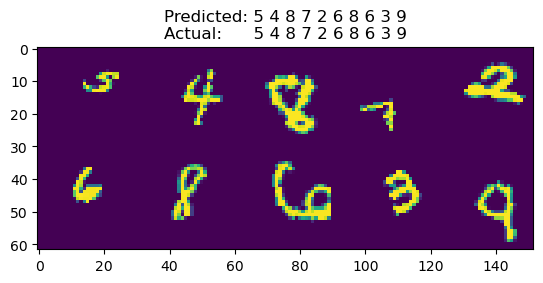

In [6]:
inputs, classes = next(iter(train_dataloader))
outputs = train_dict.get('model')(inputs) #type: ignore
_, predicted = torch.max(outputs, 1)
out = make_grid(inputs, nrow=5)
title = 'Predicted: '+' '.join(f'{j}' for j in predicted)+'\nActual:      '+\
    ' '.join((f'{j}' for j in classes))
imshow(out, title = title)
